<a href="https://colab.research.google.com/github/barrosm/text_mining/blob/master/trabalho_final_Monica_Barros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monica Barros #
# Trabalho final de BI #
## Data de entrega: 08/02/2020 ##

## Crie wordclouds para empresa, estado e serviço com intuito de saber qual é a empresa com mais reclamações.

## Para as reclamações retire os dados null, faça uma tokenização e logo um stopwords crie depois uma wordcloud. 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Informações sobre a placa NVDIA da VM (se houver)
!nvidia-smi  #comando da placa nvdia pra saber o que está rodando

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
import os
workdir_path = '/content/drive/My Drive/BIMaster_2019/trabalho_leonardo/' 
os.chdir(workdir_path)


## Inicialização #


In [5]:
!pip install nltk
import nltk


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import seaborn as sns; 
sns.set(rc={'figure.figsize':(17,6)})

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

import re
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator




# Exibe diretório atual e versões de principais módulos
current_dir = os.getcwd()
print('')
print('Diretório Atual: ',current_dir)
print('')
print('Versão Pandas :', pd.__version__)
print('')
print('Versão Numpy :', np.__version__)
print('')
print('Versão Seaborn :', sns.__version__)


Diretório Atual:  /content/drive/My Drive/BIMaster_2019/trabalho_leonardo

Versão Pandas : 0.25.3

Versão Numpy : 1.17.5

Versão Seaborn : 0.9.0


## Leitura dos Dados ##

In [0]:
df = pd.read_csv('base reclamações.csv', sep = ';', encoding = 'latin1')


In [0]:
# Renomeando a última coluna
df.columns = ['Regiao ','estado','empresa','subsidiaria  ','area ','serviço','problema','faixa etaria']

In [8]:
df.shape

(42307, 8)

Existem 42307 linhas na base de reclamações.

In [0]:
#df.head(3)

In [0]:
#df.tail(3)

In [11]:
# Número de missings/vNaNs em cada coluna
df.isnull().sum()

Regiao              0
estado              0
empresa             1
subsidiaria      6530
area             5329
serviço             0
problema         8936
faixa etaria        0
dtype: int64

## Análise por empresa e Estado

In [12]:
# Cria uma cópia do dataframe original com apenas 4 colunas, verifica o número de NaNs e elimina-os se necessário
df2 = df.copy()  
df2 = df2[['estado', 'empresa', 'serviço', 'problema']]
df2.head()

,estado,empresa,serviço,problema
0,SP,ITAÚ UNIBANCO S/A,Outros Contratos,"Contrato (não cumprimento, alteração, transfer..."
1,SP,CLARO S/A,Telefonia Fixa ( Plano de Expansão / Compra e ...,Contrato - Rescisão/alteração unilateral
2,SP,ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,Energia Elétrica,PID - Pedido de Indenização por Danos Morais
3,SP,GNN GARAGENS LTDA - EPP,"Estacionamento ( Particular, Supermercado, Sho...","Vicio de qualidade (mal executado, inadequado,..."
4,SP,CLARO S/A,Telefonia Fixa ( Plano de Expansão / Compra e ...,"Vicio de qualidade (mal executado, inadequado,..."


**Na célula a seguir verificamos que não existem valores faltantes no Dataframe que contém apenas as colunas 'estado', 'empresa', 'servico' e 'problema'.**

In [13]:
df2 = df2.dropna()
df2.isna().sum()

estado      0
empresa     0
serviço     0
problema    0
dtype: int64

In [0]:
# Força a conversão das colunas para string

df2['empresa'] = df2.empresa.apply(str)
df2['serviço'] = df2.serviço.apply(str)
df2['problema'] = df2.problema.apply(str)

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33371 entries, 0 to 42306
Data columns (total 4 columns):
estado      33371 non-null object
empresa     33371 non-null object
serviço     33371 non-null object
problema    33371 non-null object
dtypes: object(4)
memory usage: 1.3+ MB


## Etapas de pré-processamento de texto - remova números, letras maiúsculas e pontuação

In [16]:
# Quais são as empresas mais frequentes?
df2.empresa.value_counts(normalize=True)

TELEFONICA BRASIL S/A                                0.024362
CLARO S/A                                            0.019118
ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO    0.014384
TIM CELULAR S/A                                      0.012256
VIA VAREJO S/A                                       0.009619
                                                       ...   
CRIATTO DESIGN                                       0.000030
PIGNATON CONSULTING LTDA                             0.000030
NORTE IMAGEM E DIAGNOSTICO LTDA                      0.000030
BRAZILIA SECURITIES CIA.DE SECURITIZAÇÃO             0.000030
MASTERSHOPMAGAZINE                                   0.000030
Name: empresa, Length: 8928, dtype: float64

In [17]:
# Quais são os serviços mais frequentes?
df2.serviço.value_counts(normalize=True)

Telefone ( Convencional, Celular, Interfone, Etc. )                                                                                               0.120943
Telefonia Celular                                                                                                                                 0.075305
Telefonia Fixa ( Plano de Expansão / Compra e Venda / Locação )                                                                                   0.070750
Banco comercial                                                                                                                                   0.054568
Cartão de Crédito                                                                                                                                 0.053999
                                                                                                                                                    ...   
Frutas e hortaliças (legumes, verduras, cebola e cabeça de alho in nat

In [18]:
# Quais são os problemas mais frequentes?
df2.problema.value_counts(normalize=True)

Produto com vício                                                  0.181085
Cobrança indevida/abusiva                                          0.140691
Cobrança indevida.                                                 0.098049
Peso, volume e quantidade                                          0.051722
Garantia (Abrangência, cobertura, etc.)                            0.043091
                                                                     ...   
Falta de registro/alvará/autorização junto ao órgão competente     0.000030
Calculo de caução                                                  0.000030
Cobiling                                                           0.000030
Reajuste sem previsão contratual                                   0.000030
Acidente de Consumo (causou danos pessoais, físicos, mal estar)    0.000030
Name: problema, Length: 167, dtype: float64

In [0]:
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)

# Substitui s/a por '', epp por '', ltda por ''
punc_re = lambda x: re.sub(r"s/a|epp|ltda", ' ' , x.lower())
#punc_re = lambda x: re.sub(r"epp", ' ', x.lower())
#punc_re = lambda x: re.sub(r"ltda", ' ', x.lower())

# Converte para minúscula
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove espaços extras
punc_remove_extra_spaces = lambda x: str.rstrip(x)

In [0]:
df3 = df2.copy()

In [21]:
import string

# Processa o texto da coluna 'empresa'
df3['empresa'] = df3.empresa.map(punc_re).map(alphanumeric).map(punc_lower).map(punc_remove_extra_spaces)
# Processa o texto da coluna 'servico'
df3['serviço'] = df3.serviço.map(punc_re).map(alphanumeric).map(punc_lower).map(punc_remove_extra_spaces)
# Processa o texto da coluna 'problema'
df3['problema'] = df3.problema.map(punc_re).map(alphanumeric).map(punc_lower).map(punc_remove_extra_spaces)

df3.head()

,estado,empresa,serviço,problema
0,SP,itaú unibanco,outros contratos,contrato não cumprimento alteração transfer...
1,SP,claro,telefonia fixa plano de expansão compra e ...,contrato rescisão alteração unilateral
2,SP,eletropaulo metropolitana eletricidade de s paulo,energia elétrica,pid pedido de indenização por danos morais
3,SP,gnn garagens,estacionamento particular supermercado sho...,vicio de qualidade mal executado inadequado ...
4,SP,claro,telefonia fixa plano de expansão compra e ...,vicio de qualidade mal executado inadequado ...


In [22]:
df3.empresa.head()

0                                        itaú unibanco
1                                                claro
2    eletropaulo metropolitana eletricidade de s paulo
3                                         gnn garagens
4                                                claro
Name: empresa, dtype: object

In [23]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
# Cria lista de stopwords em português
stopWords_list = list(stopwords.words('portuguese'))
len(stopWords_list)
stopWords_list.sort()
stopWords_list[0:10]

['a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até']

## Wordcloud para empresa

In [0]:
# Defina lista de palavras a serem eliminadas
CLEANING_LST = ['ltda','s/a','/', 'de', 'do', 'kd','s', 'a', 'me', 'com'] + stopWords_list
CLEANING_LST.sort()

In [26]:
len(CLEANING_LST)

214

In [27]:
# Cria bloco de texto a partir da informação das empresas

text = " ".join(linha for linha in df3.empresa)
print ("Existem {} palavras na combinação de todas as reclamações.".format(len(text)))

token_text = nltk.word_tokenize(text, language='portuguese')

print("Tokenização Completada!")

Existem 890097 palavras na combinação de todas as reclamações.
Tokenização Completada!


In [33]:
print(type(text))

print(len(text))

<class 'str'>
890097


In [34]:
print(type(token_text))

print(len(token_text))

<class 'list'>
130216


## Wordcloud para empresas

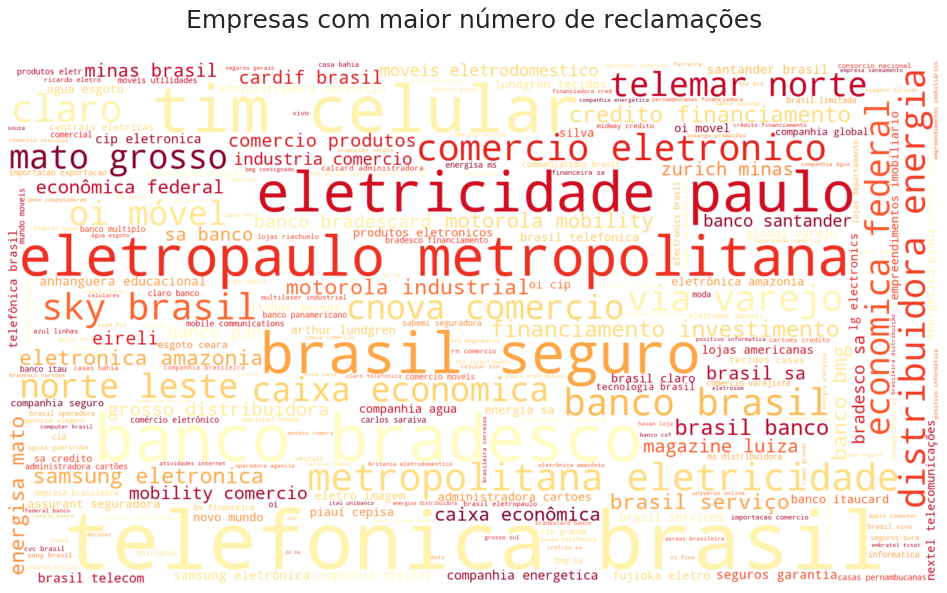

In [35]:

wordcloud = WordCloud(stopwords=CLEANING_LST, background_color="white", 
                      colormap = 'YlOrRd', max_words = 250, width=1600, 
                      height=900, random_state=42).generate(text)

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.title('Empresas com maior número de reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

## Wordcloud para Estados

In [40]:
df3.estado.value_counts().sort_values(ascending = False)

SP    7472
MS    4714
GO    4077
MT    3219
RN    2621
MG    2198
PI    2153
RO    2057
CE    1766
SC    1435
ES     633
TO     567
PB     302
RS      90
MA      60
PA       4
PE       3
Name: estado, dtype: int64

Existem 100112 palavras na combinação de todas as reclamações por Estado.


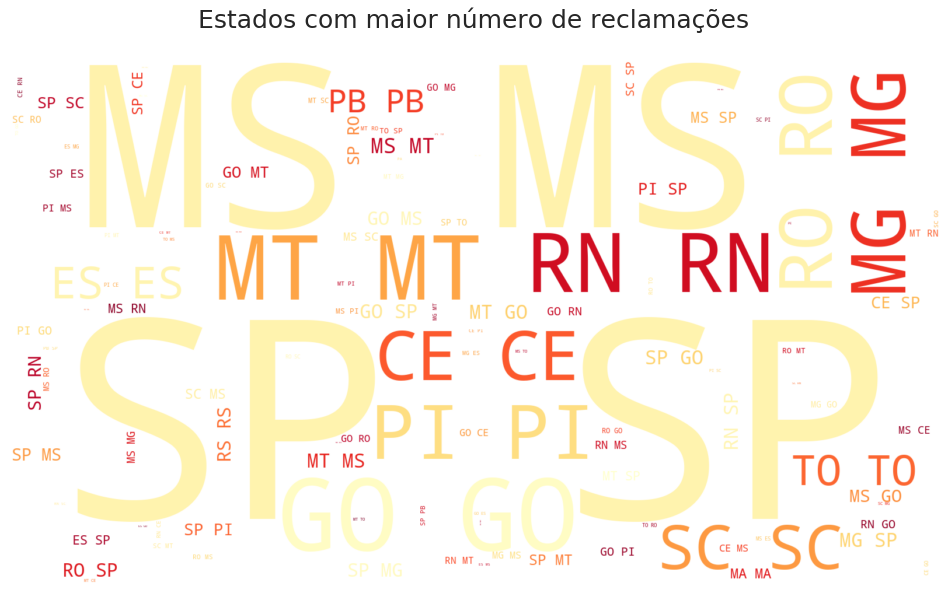

In [37]:
# Cria bloco de texto a partir da informação dos Estados

text = " ".join(linha for linha in df3.estado)
print ("Existem {} palavras na combinação de todas as reclamações por Estado.".format(len(text)))

wordcloud = WordCloud(stopwords=CLEANING_LST, background_color="white", 
                      colormap = 'YlOrRd', max_words = 250, width=1600, 
                      height=900, random_state=42).generate(text)

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.title('Estados com maior número de reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

In [41]:
df3.estado.head()

0    SP
1    SP
2    SP
3    SP
4    SP
Name: estado, dtype: object

In [43]:
text[0:110]

'SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP SP'

In [0]:
import itertools

def viz_wordcloud(dataframe,column_name): 
#Count words or phrases 
  lst_tokens = list(itertools.chain.from_iterable(dataframe[column_name])) 
  lst_phrases = [phrase.replace(" ","_") for phrase in lst_tokens] 
  wordcloud = WordCloud(
    background_color="white", max_words=2000, max_font_size=40, 
    random_state=42).generate(" ".join(lst_phrases)) 
    
#We add a following line to the viz_wordcloud function in order 
#to filter out all phrases containing irrelevant words:
  lst_phrases = [phrase for phrase in lst_phrases if not 
               any(spam in phrase.lower() for spam in CLEANING_LST)]

#We also noticed that our wordcloud contains one letter tokens that are 
#useless for our analysis. We add the following line to the viz_wordcloud 
#function to remove them:

  lst_phrases = [phrase.replace(" ","_") for phrase in lst_phrases 
               if len(phrase) > 1 ] 
    # Display the generated image: 
  
    # the matplotlib way: 
  plt.figure(figsize = (16,9)) 
  plt.imshow(wordcloud, interpolation='bilinear') 
  plt.axis("off") 
  plt.show() 


In [0]:
viz_wordcloud(df3,'empresa')

ValueError: ignored

In [0]:

# Agrupamos por texto que se encontra entre 2 ponto.
sentences = [list(group) for k, group in groupby(text, lambda x: x == ".")\
                             if not k]

# Remove stopwords numbers and punctuation.

def preprocess(sentence):
  return [word for word in sentence\
                if word not in stop_words and word.isalpha()]

sentences = [preprocess(sentence) for sentence in sentences]

# Seleccionamos frases com dimensão entre 3 e 150 palavras.
sentences =  [sentence for sentence in sentences\
                        if len(sentence)>3 and len(sentence)<150]

In [0]:
# Salva wordcloud em arquivo
####wordcloud.to_file("img/first_review.png")
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)

In [0]:
data['tokens'] = data.reviews.map(word_tokenize)
data.head()